# Preparing new pretraining data

We want to update our pretraining data, to add more data and improve the associated metadata. Here is a list of changes
- we were to aggressive at removing outlier samples for some studies, so we want to make sure more samples are included
- we want to add new studies to the pretraining data
- some of the metadata was incomplete previously, we want to fix that

other possible changes
- include studies that were previously aligned, but excluded to not the best alignment

In [56]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
x_rcc_test_file = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/April_30_Finetune_Data/X_finetune_test.csv'
x_rcc_test = pd.read_csv(x_rcc_test_file, index_col=0)
pretrain_feats = x_rcc_test.columns

save_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/July_09_Data'
os.makedirs(save_dir, exist_ok=True)

In [15]:
def align_to_existing(input_intensity_matrix, pretrain_features, align_input, 
                      fill_na=False, std_scale=False, log2_scale=False):
    """
    Aligns input intensity matrix with pretrain features based on align input.

    Parameters:
    - input_intensity_matrix (pd.DataFrame): The input intensity matrix to align. Columns are features and rows are samples.
    - pretrain_features (list or pd.Index): The list or pd.Index of features used for pretraining (correspond to reference study features)
    - align_input (pd.DataFrame or pd.Series): The align input to use for alignment. has index of features from the reference study, 
    and values of the features from the input_intensity_matrix to align.
    - fill_na (bool, optional): Whether to fill missing values. Defaults to False. Missing values within the input study, 
        are filled by taking the average feature value, while features not present in the input study are filled by taking the average sample value.
    - std_scale (bool, optional): Whether to standardize the intensity matrix. Defaults to False.
    - log2_scale (bool, optional): Whether to log2 transform the intensity matrix. Defaults to False.

    Returns:
    - intensity_df (pd.DataFrame): The aligned intensity matrix.
    - nan_df (pd.DataFrame): A boolean DataFrame indicating missing values in the aligned intensity matrix.
    """
    if not isinstance(input_intensity_matrix, pd.DataFrame):
        raise ValueError('input_intensity_matrix should be a pandas DataFrame')

    if 'FT' not in input_intensity_matrix.columns[0][:2]:
        input_intensity_matrix = input_intensity_matrix.T

    if isinstance(align_input,pd.DataFrame):
        align_input = align_input.iloc[:,0].copy()

    common_pretrained_features = list(set(pretrain_features).intersection(align_input.index))
    print('Common pretrained features:', common_pretrained_features)
    missing_pretrained_features = list(set(pretrain_features).difference(align_input.index))
    print('Missing pretrained features:', missing_pretrained_features)
    align_input = align_input[common_pretrained_features].copy()
    
    input_features_aligned = align_input.values.tolist()
    pretrain_features_aligned = align_input.index.tolist()
    if isinstance(pretrain_features, pd.Index):
        pretrain_features = pretrain_features.tolist()
    

    output_matrix = np.empty((input_intensity_matrix.shape[0], len(pretrain_features)), dtype=float)
    output_matrix = output_matrix * np.nan
    output_matrix[:, [pretrain_features.index(f) for f in pretrain_features_aligned]] = input_intensity_matrix[input_features_aligned].values

    intensity_df = pd.DataFrame(output_matrix, index=input_intensity_matrix.index, columns=pretrain_features)
    nan_df = intensity_df.isnull()

    if log2_scale:
        intensity_df = np.log2(intensity_df + 1)

    if std_scale:
        scaler = StandardScaler()
        intensity_df = pd.DataFrame(scaler.fit_transform(intensity_df), index=intensity_df.index, columns=intensity_df.columns)
        
    if fill_na:
        # Fill partial missing values with the mean of the feature
        partial_missing = intensity_df.loc[:,pretrain_features_aligned].copy()
        full_missing = intensity_df.loc[:, [f for f in pretrain_features if f not in pretrain_features_aligned]].copy()
        partial_missing.fillna(partial_missing.mean(), inplace=True)

        # fill complete missing values rest with the mean of row
        full_missing = full_missing.T
        full_missing.fillna(intensity_df.mean(axis=1), inplace=True)
        full_missing = full_missing.T

        intensity_df = pd.concat([partial_missing, full_missing], axis=1)
        intensity_df = intensity_df[pretrain_features]


    return intensity_df, nan_df


In [4]:
def load_raw_data(main_dir, num, alignment_df):
    peaks_intensity_file = f'{main_dir}/{num}_final_peaks_intensity_max.csv'
    peak_info_file = f'{main_dir}/{num}_final_peaks_peak_info.csv'

    peaks_intensity = pd.read_csv(peaks_intensity_file, index_col=0)
    peak_info = pd.read_csv(peak_info_file, index_col=0)

    selected_peaks = alignment_df[f'{num}'].copy()
    selected_peaks.dropna(inplace=True)
    peak_info = peak_info.loc[selected_peaks.values].copy()
    peaks_intensity = peaks_intensity.loc[selected_peaks.values].copy()
    
    peak_info.index = selected_peaks.index.tolist()
    peaks_intensity.index = selected_peaks.index.tolist()

    peak_info['exists'] = 1
    return peaks_intensity, peak_info

In [34]:
import seaborn as sns
import umap
from sklearn.decomposition import PCA

def generate_pca_embedding(matrix, n_components=2):
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(matrix.T)
    if isinstance(matrix, pd.DataFrame):
        embedding = pd.DataFrame(embedding, index=matrix.columns, columns=[f'PCA{i+1}' for i in range(n_components)])
    return embedding

def generate_umap_embedding(matrix, n_components=2):

    reducer = umap.UMAP(n_components=n_components)
    embedding = reducer.fit_transform(matrix.T)
    if isinstance(matrix, pd.DataFrame):
        embedding = pd.DataFrame(embedding, index=matrix.columns, columns=[f'UMAP{i+1}' for i in range(n_components)])
    return embedding

def plot_pca(embedding,metadata,col_name,yes_umap=False):

    if yes_umap:
        xvar = 'UMAP1'
        yvar = 'UMAP2'
    else:
        xvar = 'PCA1'
        yvar = 'PCA2'
    if metadata[col_name].nunique() < 10:
        palette = sns.color_palette("tab10", metadata[col_name].nunique())
        sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=metadata[col_name], palette=palette)
    else:
        sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=metadata[col_name])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=col_name)
    plt.xlabel(xvar)
    plt.ylabel(yvar)

    # add counts to the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if metadata[col_name].nunique() < 15:
        labels = [f'{x} ({metadata[metadata[col_name]==x].shape[0]})' for x in labels]
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=col_name,
            ncol=2)  # ncol=2 makes the legend have 2 columns

    # add the number of samples to the title
    plt.title(f'N samples = {metadata[~metadata[col_name].isna()].shape[0]}')


## Add the Stanford BMI Data set

In [9]:
standford_data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/stanford-hmp2'

new_alignment_df = pd.read_csv(f'{standford_data_dir}/alignment_df.csv', index_col=0)
# intensity_matrix = pd.read_csv(f'{main_dir}/combined_study.csv', index_col=0)
new_alignment_df.dropna(axis=0, how='all', inplace=True)


In [48]:
new_metadata = pd.read_csv(f'{standford_data_dir}/stanford-hmp2_metadata.tsv', index_col=0, sep='\t')

new_metadata['file name'] = new_metadata.index
new_metadata['mzml_file'] = new_metadata['file name'].apply(lambda x: x+'.mzML')
new_metadata.index = new_metadata['mzml_file']
sample_info = pd.read_csv(f'{standford_data_dir}/sample_info.csv', index_col=0)
new_metadata =new_metadata.join(sample_info,how='outer')

In [11]:

poolmap_intensity = pd.read_csv(f'{standford_data_dir}/final_peaks_intensity_max_pool_map_norm.csv', index_col=0)
intensity_df, nan_df = align_to_existing(poolmap_intensity.T, pretrain_feats, new_alignment_df['627'], fill_na=True, std_scale=True, log2_scale=True)

/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [52]:
embedding0 = generate_pca_embedding(intensity_df.T).values


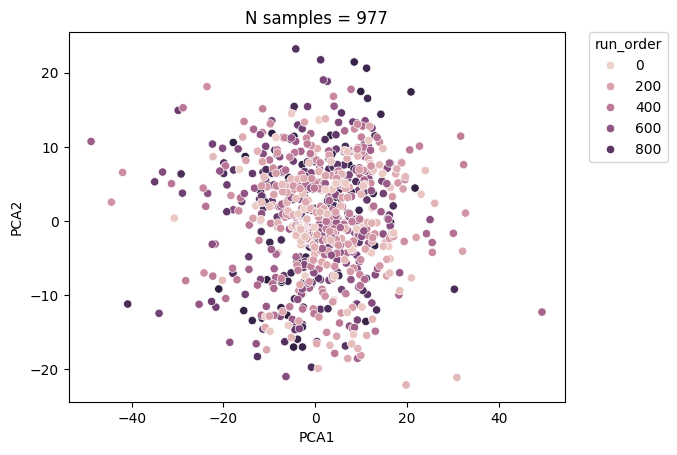

In [53]:
# embedding0 = generate_pca_embedding(intensity_df)
# embedding1 = generate_umap_embedding(new_matrix)
plot_pca(embedding0,new_metadata,col_name='run_order',yes_umap=False)

In [58]:
# save the data 
intensity_df.to_csv(f'{save_dir}/stanford_hmp2_scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/stanford_hmp2_nan_matrix.csv')
new_metadata.to_csv(f'{save_dir}/stanford_hmp2_metadata.csv')



## Add the Shanghai Lung Cancer Data

Already combined the data using `shanghai_lungcancer_May30.ipynb`

In [59]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST002773_Shanghai_LungCancer'

alignment_df = pd.read_csv(f'{data_dir}/alignment_df.csv', index_col=0)

In [60]:
alignment_df

,623,626,624,625
541,,,,
NaN,NaN,NaN,NaN,NaN
FT10040,FT5342,FT5111,FT5365,FT5313
FT10041,FT5337,NaN,NaN,NaN
FT10068,NaN,FT5134,NaN,FT5355
FT10089,FT5372,FT5131,NaN,FT5336
...,...,...,...,...
FT9914,FT5267,FT5058,FT5303,FT5250
FT9916,FT5276,FT5047,FT5314,FT5249
FT9972,FT5312,FT5090,FT5337,FT5292


In [581]:


# intensity_matrix = pd.read_csv(f'{data_dir}/combined_alignment_46_grid_0/final_peaks/intensity_max_synthetic_norm.csv', index_col=0)
# intensity_matrix = pd.read_csv(f'{data_dir}/combined_alignment_46_grid_0/final_peaks/intensity_max_pool.csv', index_col=0)
intensity_matrix = pd.read_csv(f'{data_dir}/combined/final_peaks/intensity_max_pool.csv', index_col=0)
peak_info = pd.read_csv(f'{data_dir}/combined/final_peaks/peak_info.csv', index_col=0)
# nan_matrix = intensity_matrix.isna()

In [580]:
metadata = pd.read_csv(f'{data_dir}/metadata_complete.csv', index_col=0)
metadata = metadata.loc[intensity_matrix.columns].copy()
metadata['Ref'] = metadata['Pool'].astype(int)
metadata['batch_id'] = metadata['Batch'].astype(int)

In [179]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler



# # Apply log2 transformation
# combined_norm_int_log2 = np.log2(intensity_matrix).T
# combined_norm_int_log2 = combined_norm_int_log2[peak_info[peak_info['freq'] > 0.6].index.tolist()].copy()
# # Apply standard scaler transformation
# scaler = StandardScaler()
# combined_norm_int_scaled = scaler.fit_transform(combined_norm_int_log2)
# combined_norm_int_scaled = pd.DataFrame(combined_norm_int_scaled, index=combined_norm_int_log2.index)

(3455, 563)


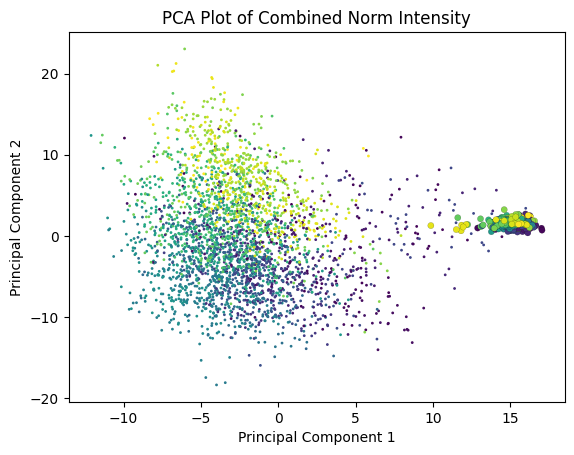

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# Apply log2 transformation
combined_norm_int_log2 = np.log2(intensity_matrix).T
combined_norm_int_log2 = combined_norm_int_log2[peak_info[peak_info['freq'] > 0.6].index.tolist()].copy()
# Apply standard scaler transformation
scaler = StandardScaler()
combined_norm_int_scaled = scaler.fit_transform(combined_norm_int_log2)
combined_norm_int_scaled = pd.DataFrame(combined_norm_int_scaled, index=combined_norm_int_log2.index)



print(combined_norm_int_scaled.shape)
# Perform PCA
pca = PCA(n_components=2)
combined_norm_int_scaled.fillna(0, inplace=True)
pca_result = pca.fit_transform(combined_norm_int_scaled)

run_order = metadata.loc[combined_norm_int_scaled.index,'run_order'].values
ref_samples = metadata.loc[combined_norm_int_scaled.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=metadata['run_order'].max())

# Create PCA plot
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=run_order, cmap='viridis', s=1, norm=color_norm)

plt.scatter(pca_result[:, 0][ref_samples.astype(bool)], 
            pca_result[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=20, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

In [460]:
intensity_matrix.shape

(1526, 3455)

In [582]:
intensity_matrix

,F076_200714_M331_001.mzML,F076_200714_M331_009.mzML,F076_200714_M331_017.mzML,F076_200714_M331_025.mzML,F076_200714_M331_033.mzML,F076_200714_M331_041.mzML,F076_200714_M331_049.mzML,F076_200714_M331_057.mzML,F076_200714_M331_065.mzML,F076_200714_M331_073.mzML,...,F076_201011_M331_209.mzML,F076_201011_M331_217.mzML,F076_201011_M331_225.mzML,F076_201011_M331_233.mzML,F076_201011_M331_241.mzML,F076_201011_M331_249.mzML,F076_201011_M331_257.mzML,F076_201011_M331_265.mzML,F076_201011_M331_273.mzML,F076_201011_M331_281.mzML
FT10040,14941.562,NaN,11787.7930,16726.055,NaN,8010.011,10173.402,14102.483,6746.3450,NaN,...,3795.2415,3092.9617,4329.3354,7676.4480,5448.082,5902.2285,6469.2770,14941.562,NaN,NaN
FT10041,42115.580,3471.440,4959.5464,7887.721,5743.2837,6464.715,9258.850,9289.512,NaN,17430.416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FT10068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FT10089,95444.836,95444.836,20452.5490,28792.367,56541.4380,19264.451,30673.290,40674.957,17685.5490,30323.695,...,40049.3440,27835.9280,21277.1170,41143.0940,63106.516,38014.3480,37516.1560,95444.836,95444.836,NaN
FT10091,234721.600,229389.700,87425.1500,86333.055,202900.8600,112891.770,91865.016,116852.310,NaN,74337.195,...,106568.5000,68787.7600,82136.5400,94622.2600,206190.800,99149.3360,94807.0860,198889.900,247623.610,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FT9914,95790.200,95790.200,169501.7000,290774.400,32019.7100,224171.830,942178.300,104008.450,190065.1900,711946.800,...,51834.3870,199757.9500,153986.3600,75307.7100,65818.240,170065.1200,68443.1300,95790.200,95790.200,NaN
FT9916,40932.880,40932.880,14050.0370,15618.584,NaN,17966.280,33984.110,40137.387,8672.5625,17928.371,...,8415.4590,17660.6520,18670.2130,12561.8790,10214.681,14213.7030,12889.7440,40932.880,40932.880,NaN
FT9972,56451.280,56451.280,36462.4500,175308.670,150154.9500,41028.723,185485.620,94401.340,64429.6300,112881.170,...,56485.9960,39669.1000,33073.5200,26273.0980,88469.040,49576.1370,35604.9340,56451.280,56451.280,NaN
FT9975,NaN,165785.200,54662.9920,20574.310,63192.1760,96971.664,NaN,NaN,NaN,15344.409,...,39545.0230,43593.0100,77548.1100,67056.7900,61482.850,57295.6370,73491.4300,165785.200,165785.200,NaN


In [584]:
new_matrix = intensity_matrix.T.copy()
nan_matrix = new_matrix.isna()
new_matrix.fillna(new_matrix.mean(), inplace=True)

scaler = StandardScaler()
intensity_matrix_scaled = scaler.fit_transform(new_matrix)
intensity_matrix_scaled = pd.DataFrame(intensity_matrix_scaled, index=new_matrix.index, columns=new_matrix.columns)


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [585]:
intensity_matrix_scaled

,FT10040,FT10041,FT10068,FT10089,FT10091,FT10097,FT10098,FT10100,FT10101,FT10104,...,FT9903,FT9905,FT9911,FT9912,FT9913,FT9914,FT9916,FT9972,FT9975,FT9980
F076_200714_M331_001.mzML,-1.578331e-01,0.748433,-1.051442e-15,1.071053,1.596435,9.652436e-01,2.137347e-16,3.372423e-16,2.963685e-01,-4.660346e-01,...,-1.169489e-15,-0.469282,0.387517,6.080635e-01,0.407106,-3.415218e-01,4.966359e-01,-0.332103,3.110396e-16,0.436605
F076_200714_M331_009.mzML,1.268925e-16,-2.303442,-1.051442e-15,1.071053,1.496027,3.249452e-16,2.137347e-16,3.372423e-16,1.140839e+00,1.607501e-16,...,-1.169489e-15,-0.469282,0.387517,6.080635e-01,0.407106,-3.415218e-01,4.966359e-01,-0.332103,1.779246e+00,0.000000
F076_200714_M331_017.mzML,-2.678364e-01,-2.185920,-1.051442e-15,-1.681753,-1.177382,3.249452e-16,2.137347e-16,3.372423e-16,-7.786468e-01,-7.929551e-01,...,-1.169489e-15,-0.785316,-1.019334,-8.949591e-01,-0.005361,3.760312e-01,-9.240686e-01,-0.794643,-5.959335e-01,-0.726396
F076_200714_M331_025.mzML,-9.559012e-02,-1.954671,-1.051442e-15,-1.375616,-1.197948,3.645618e+00,2.137347e-16,3.372423e-16,-8.699466e-01,1.607501e-16,...,-1.169489e-15,-0.986018,0.303809,-7.928754e-01,1.950753,1.556574e+00,-8.411740e-01,2.418245,-1.324561e+00,0.053577
F076_200714_M331_033.mzML,1.268925e-16,-2.124026,-1.051442e-15,-0.357007,0.997202,2.401776e-01,2.137347e-16,3.372423e-16,-7.026889e-01,-7.311092e-01,...,-1.169489e-15,-0.055277,0.000000,-2.768820e-16,-0.874005,-9.623029e-01,-1.922599e-16,1.836191,-4.136266e-01,-1.080720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F076_201011_M331_249.mzML,-4.731245e-01,0.000000,-1.051442e-15,-1.037097,-0.956598,3.249452e-16,2.137347e-16,3.372423e-16,-2.597086e-16,-9.076992e-01,...,2.294659e+00,-0.896825,0.678476,-9.091621e-01,0.748755,3.815159e-01,-9.154191e-01,-0.491194,-5.396621e-01,-0.867680
F076_201011_M331_257.mzML,-4.533459e-01,0.000000,-1.051442e-15,-1.055384,-1.038369,3.249452e-16,-6.578219e-01,-1.026292e+00,-1.052137e+00,-7.133846e-01,...,-4.770479e-01,-0.999307,-0.871242,-8.775750e-01,-0.365536,-6.077350e-01,-9.853877e-01,-0.814486,-1.934854e-01,-1.037250
F076_201011_M331_265.mzML,-1.578331e-01,0.000000,-1.051442e-15,1.071053,0.921669,9.163257e-01,-4.058256e-01,-6.343507e-02,3.115905e+00,-2.375814e-01,...,3.957618e+00,-0.469282,0.387517,6.080635e-01,0.407106,-3.415218e-01,4.966359e-01,-0.332103,1.779246e+00,-0.929407
F076_201011_M331_273.mzML,1.268925e-16,0.000000,-1.051442e-15,1.071053,1.839399,1.004240e+00,1.571071e-01,1.061044e+00,9.978108e-01,3.761506e-01,...,3.588025e+00,-0.469282,0.387517,6.080635e-01,0.407106,-3.415218e-01,4.966359e-01,-0.332103,1.779246e+00,0.000000


In [586]:
nan_matrix

,FT10040,FT10041,FT10068,FT10089,FT10091,FT10097,FT10098,FT10100,FT10101,FT10104,...,FT9903,FT9905,FT9911,FT9912,FT9913,FT9914,FT9916,FT9972,FT9975,FT9980
F076_200714_M331_001.mzML,False,False,True,False,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,True,False
F076_200714_M331_009.mzML,True,False,True,False,False,True,True,True,False,True,...,True,False,False,False,False,False,False,False,False,True
F076_200714_M331_017.mzML,False,False,True,False,False,True,True,True,False,False,...,True,False,False,False,False,False,False,False,False,False
F076_200714_M331_025.mzML,False,False,True,False,False,False,True,True,False,True,...,True,False,False,False,False,False,False,False,False,False
F076_200714_M331_033.mzML,True,False,True,False,False,False,True,True,False,False,...,True,False,True,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F076_201011_M331_249.mzML,False,True,True,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
F076_201011_M331_257.mzML,False,True,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
F076_201011_M331_265.mzML,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
F076_201011_M331_273.mzML,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [587]:
# save the data 
intensity_matrix_scaled.to_csv(f'{save_dir}/shanghai_lung_cancer_scaled_intensity_matrix.csv')
nan_matrix.to_csv(f'{save_dir}/shanghai_lung_cancer_nan_matrix.csv')
metadata.to_csv(f'{save_dir}/shanghai_lung_cancer_metadata.csv')

# Add back Studies previously aligned

In [588]:
org_alignment_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/'

alignment_df = pd.read_csv(f'{org_alignment_dir}/alignment_df.csv', index_col=0)

## Add ST000601 

Untargeted LC-MS metabolomics analysis of human COPD plasma
correspond to cohort id 547

In [658]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST000601/job_id_547'
cohort_id = 547

cohort_align = alignment_df[f'{cohort_id}'].dropna()

In [659]:
cleaned_metadata_file = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/source_metadata/metadata_2025_july_05/metadata_ST000601.csv'

In [660]:
sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)

metadata = pd.read_csv(cleaned_metadata_file, index_col=0)

In [661]:
sample_info = sample_info.join(metadata)
sample_info.loc[sample_info['Sex'].isna(),'Ref'] = 1

In [662]:
norm_intensity = pd.read_csv(f'{data_dir}/final_peaks/intensity_max_synthetic_map_norm.csv', index_col=0)
intensity_matrix = norm_intensity.loc[cohort_align].copy()
intensity_matrix.index = cohort_align.index
intensity_matrix.index.name = 'feats'
intensity_matrix = intensity_matrix.T

nan_matrix = intensity_matrix.isna()

In [663]:
# Fill missing values with the mean of the feature
intensity_matrix.fillna(intensity_matrix.mean(), inplace=True)

# log scale the data
intensity_matrix = np.log2(intensity_matrix)


scaler = StandardScaler()
intensity_matrix_scaled = scaler.fit_transform(intensity_matrix)
intensity_matrix_scaled = pd.DataFrame(intensity_matrix_scaled, index=intensity_matrix.index, columns=intensity_matrix.columns)

In [664]:
# save the data 
intensity_matrix_scaled.to_csv(f'{save_dir}/ST000601_scaled_intensity_matrix.csv')
nan_matrix.to_csv(f'{save_dir}/ST000601_nan_matrix.csv')


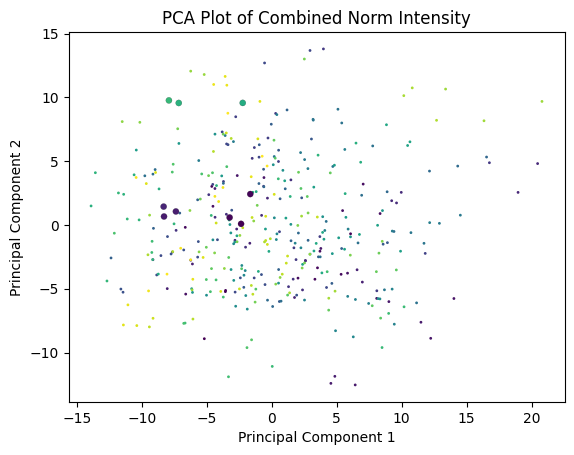

In [503]:
pca = PCA(n_components=2)
# intensity_matrix_scaled.fillna(0, inplace=True)
pca_result = pca.fit_transform(intensity_matrix_scaled)

run_order = sample_info.loc[intensity_matrix_scaled.index,'run_order'].values
ref_samples = sample_info.loc[intensity_matrix_scaled.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=sample_info['run_order'].max())

# Create PCA plot
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=run_order, cmap='viridis', s=1, norm=color_norm)

plt.scatter(pca_result[:, 0][ref_samples.astype(bool)], 
            pca_result[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=20, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

## Add ST001422, ST001423

Previously I think I was too quick to remove outliers from this dataset. 
between these two studies, there are another 94 samples that have Sex
with 48 of those having Age, BMI and cancer information. So we will add these samples back in.

ST001423 corresponds to job ids: 526,  619

ST001422 corresponds to job ids: 502, 618

#### ST001423


In [665]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST001423/job_id_526'
cohort_id = 526

cohort_align = alignment_df[f'{cohort_id}'].dropna()

In [666]:
sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)

In [667]:
norm_intensity = pd.read_csv(f'{data_dir}/final_peaks/intensity_max_synthetic_norm.csv', index_col=0)
intensity_matrix = norm_intensity.loc[cohort_align].copy()
intensity_matrix.index = cohort_align.index
intensity_matrix.index.name = 'feats'
intensity_matrix = intensity_matrix.T

nan_matrix = intensity_matrix.isna()

In [668]:
intensity_matrix

feats,FT10041,FT10042,FT10044,FT1006,FT1007,FT10089,FT10090,FT10094,FT10097,FT1011,...,FT9934,FT9935,FT994,FT9951,FT9968,FT9975,FT9980,FT9984,FT9989,FT9999
VT_160716_M198_001.mzML,8.587461e+05,875294.633297,2.105062e+06,207404.771345,4.405317e+06,526410.528579,419229.123493,487331.050081,1.109945e+06,NaN,...,NaN,8.381529e+06,3.743550e+06,2.211643e+06,465997.035612,1.214327e+06,520103.844073,NaN,277010.506008,2.479358e+06
VT_160716_M198_003.mzML,9.124619e+05,788112.049087,2.043122e+06,NaN,4.102777e+06,401145.816077,383430.438921,NaN,1.124473e+06,NaN,...,NaN,8.184426e+06,3.628291e+06,1.928441e+06,471357.607034,1.109147e+06,NaN,NaN,344385.839425,2.441805e+06
VT_160716_M198_005.mzML,1.085484e+06,727272.263688,2.280466e+06,NaN,3.411883e+06,485499.889783,457777.059491,438174.099965,1.010791e+06,NaN,...,NaN,8.601969e+06,3.884411e+06,2.004410e+06,587174.359912,1.313723e+06,616412.861182,NaN,315028.869924,2.665575e+06
VT_160716_M198_007.mzML,1.759386e+06,885801.383355,2.070463e+06,388335.218992,5.980412e+06,439659.763452,NaN,609100.143197,1.278627e+06,162901.814139,...,371806.499478,3.686614e+06,4.181504e+06,2.244477e+06,NaN,2.918046e+05,286348.556513,267641.843561,907209.992047,1.005016e+06
VT_160716_M198_009.mzML,1.955679e+06,714989.789715,1.955239e+06,409881.363080,6.470084e+06,405398.762880,121787.017724,735675.070458,1.103545e+06,135628.723005,...,358228.392718,3.660749e+06,NaN,2.006932e+06,NaN,3.498907e+05,198505.969933,NaN,921778.310944,1.184717e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT_160803_M198_129.mzML,7.369636e+05,765809.278064,1.377937e+06,NaN,5.286394e+06,NaN,271429.105664,642022.660155,7.782616e+05,NaN,...,NaN,7.225843e+06,2.272651e+06,1.949130e+06,NaN,1.108616e+06,427601.061766,337810.531480,NaN,1.937405e+06
VT_160803_M198_131.mzML,6.228640e+05,672043.033123,1.541022e+06,NaN,4.251493e+06,296980.226173,288077.407170,405407.454500,6.623390e+05,NaN,...,NaN,5.499010e+06,NaN,2.030582e+06,411079.782712,9.743436e+05,NaN,293335.140024,NaN,1.810755e+06
VT_160804_M198_001.mzML,8.243157e+05,583415.370612,1.472584e+06,NaN,NaN,298806.839294,NaN,NaN,6.737382e+05,NaN,...,NaN,5.056838e+06,2.391190e+06,1.659074e+06,400267.265615,8.515235e+05,662945.381070,477828.143833,NaN,1.607529e+06
VT_160804_M198_003.mzML,6.877563e+05,686028.512447,1.484827e+06,NaN,5.017244e+06,NaN,195493.253984,NaN,7.771110e+05,NaN,...,NaN,5.228611e+06,2.089237e+06,1.782010e+06,NaN,8.674068e+05,518173.788841,348378.022315,NaN,1.638070e+06


In [669]:
cohort_align

feats
FT10041    FT8647
FT10042    FT8658
FT10044    FT8660
FT1006      FT680
FT1007      FT702
            ...  
FT9975     FT8697
FT9980     FT8650
FT9984     FT8651
FT9989     FT8678
FT9999     FT8644
Name: 526, Length: 1751, dtype: object

In [670]:
intensity_matrix.shape

(1197, 1751)

In [671]:
intensity_matrix.shape

(1197, 1751)

In [672]:
# Fill missing values with the mean of the feature
intensity_matrix.fillna(intensity_matrix.mean(), inplace=True)

# log scale the data
intensity_matrix = np.log2(intensity_matrix)


scaler = StandardScaler()
intensity_matrix_scaled = scaler.fit_transform(intensity_matrix)
intensity_matrix_scaled = pd.DataFrame(intensity_matrix_scaled, index=intensity_matrix.index, columns=intensity_matrix.columns)

In [673]:
intensity_matrix_scaled.head()

feats,FT10041,FT10042,FT10044,FT1006,FT1007,FT10089,FT10090,FT10094,FT10097,FT1011,...,FT9934,FT9935,FT994,FT9951,FT9968,FT9975,FT9980,FT9984,FT9989,FT9999
VT_160716_M198_001.mzML,-1.734509,1.066084,1.075903,-0.483385,-0.134335,1.749743,0.835509,-1.624392,1.102296,0.151047,...,0.077245,1.730425,0.114955,0.748196,1.413115,1.384066,-0.497282,0.240603,-2.558381,1.702526
VT_160716_M198_003.mzML,-1.572475,0.499922,0.901769,0.319938,-0.311860,0.066454,0.581839,0.157168,1.174984,0.151047,...,0.077245,1.648457,-0.012808,0.025352,1.486195,1.154030,0.202865,0.240603,-1.977348,1.647915
VT_160716_M198_005.mzML,-1.108762,0.066401,1.542551,0.319938,-0.771964,1.248625,1.085500,-1.971178,0.579215,0.151047,...,0.077245,1.819844,0.265858,0.229180,2.889974,1.583825,-0.080389,0.240603,-2.215141,1.961662
VT_160716_M198_007.mzML,0.180984,1.130472,0.979275,1.497050,0.628375,0.634306,0.169244,-0.896951,1.893120,-0.402405,...,1.469492,-1.098542,0.566952,0.825939,0.075536,-2.236259,-1.961830,-2.033822,0.607752,-1.528606
VT_160716_M198_009.mzML,0.463462,-0.025510,0.645419,1.667556,0.824743,0.131778,-2.677548,-0.281161,1.069968,-0.978809,...,1.235936,-1.122793,0.130693,0.235813,0.075536,-1.775330,-2.860926,0.240603,0.650270,-0.939985


In [674]:
# save the data
intensity_matrix_scaled.to_csv(f'{save_dir}/ST001423_scaled_intensity_matrix.csv')
nan_matrix.to_csv(f'{save_dir}/ST001423_nan_matrix.csv')


#### ST001422

In [675]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST001422/job_id_502'
cohort_id = 502

cohort_align = alignment_df[f'{cohort_id}'].dropna()

sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)

In [676]:
sample_info.shape

(2075, 5)

In [677]:
norm_intensity = pd.read_csv(f'{data_dir}/final_peaks/intensity_max_synthetic_map_norm.csv', index_col=0)
intensity_matrix = norm_intensity.loc[cohort_align].copy()
intensity_matrix.index = cohort_align.index
intensity_matrix.index.name = 'feats'
intensity_matrix = intensity_matrix.T

nan_matrix = intensity_matrix.isna()

In [678]:
nan_matrix

feats,FT10037,FT10039,FT10041,FT10042,FT10044,FT10046,FT1006,FT1007,FT10071,FT10089,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_160120_001.mzML,True,True,True,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,True,False,True
VT_160120_003.mzML,True,True,False,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
VT_160120_005.mzML,True,True,False,False,True,True,False,True,False,False,...,False,True,False,False,False,False,False,True,False,True
VT_160120_007.mzML,True,True,False,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
VT_160120_009.mzML,True,True,False,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT_160226_135.mzML,True,True,True,True,False,True,True,True,True,True,...,True,False,False,False,False,False,False,True,False,True
VT_160226_137.mzML,True,True,True,True,False,True,False,True,True,True,...,True,False,False,False,False,False,False,True,False,False
VT_160226_139.mzML,True,True,True,True,True,True,False,True,True,True,...,True,False,False,False,False,False,False,True,False,True
VT_160226_141.mzML,True,True,True,True,True,True,False,True,False,True,...,True,False,False,False,False,False,False,True,False,True


In [680]:
intensity_matrix.head()

feats,FT10037,FT10039,FT10041,FT10042,FT10044,FT10046,FT1006,FT1007,FT10071,FT10089,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_160120_001.mzML,NaN,NaN,NaN,187957.421165,NaN,NaN,359245.564998,NaN,1.608179e+05,495586.049898,...,NaN,3.166531e+06,9.877261e+06,4.192194e+06,6.561607e+06,1.845750e+07,4.064930e+06,NaN,1.570743e+06,NaN
VT_160120_003.mzML,NaN,NaN,107629.208539,226058.151545,NaN,NaN,332971.187200,NaN,2.366542e+05,503008.988032,...,NaN,3.543374e+06,1.129879e+07,4.050346e+06,7.434181e+06,1.591167e+07,4.353654e+06,100437.682846,1.343764e+06,NaN
VT_160120_005.mzML,NaN,NaN,83969.093770,209951.620417,NaN,NaN,472001.902783,NaN,2.820595e+05,481761.549322,...,126451.930639,NaN,1.016082e+07,4.060169e+06,6.921081e+06,1.573615e+07,4.114010e+06,NaN,1.340387e+06,NaN
VT_160120_007.mzML,NaN,NaN,129365.258391,189683.402467,NaN,NaN,351268.757686,NaN,1.254452e+06,NaN,...,NaN,4.300528e+05,1.776446e+06,3.793492e+06,8.722534e+05,4.117061e+06,3.659367e+06,290382.034718,1.015652e+06,NaN
VT_160120_009.mzML,NaN,NaN,157274.588145,184159.487516,NaN,NaN,550567.780525,NaN,9.053601e+05,NaN,...,NaN,4.486081e+05,8.895423e+05,3.960613e+06,4.134301e+05,2.839923e+06,3.377906e+06,526432.411112,9.503878e+05,NaN


In [681]:
intensity_matrix.shape

(2075, 1744)

In [682]:
# Fill missing values with the mean of the feature
intensity_matrix.fillna(intensity_matrix.mean(), inplace=True)

# log scale the data
intensity_matrix = np.log2(intensity_matrix)


scaler = StandardScaler()
intensity_matrix_scaled = scaler.fit_transform(intensity_matrix)
intensity_matrix_scaled = pd.DataFrame(intensity_matrix_scaled, index=intensity_matrix.index, columns=intensity_matrix.columns)

In [683]:
print(intensity_matrix_scaled.shape)

(2075, 1744)


In [684]:
intensity_matrix_scaled.head()

feats,FT10037,FT10039,FT10041,FT10042,FT10044,FT10046,FT1006,FT1007,FT10071,FT10089,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_160120_001.mzML,0.093245,0.087186,0.146938,-0.113207,0.193099,0.045698,0.220885,0.162623,-7.049922,2.928353,...,0.123150,5.830387,7.862187,2.201605,6.725855,8.319380,2.192188,0.256119,1.037220,0.331534
VT_160120_003.mzML,0.093245,0.087186,-0.755285,0.668846,0.193099,0.045698,-0.068341,0.162623,-5.403614,3.017734,...,0.123150,6.130938,8.362752,1.892175,7.114798,7.778943,2.756604,-2.357894,0.727733,0.331534
VT_160120_005.mzML,0.093245,0.087186,-1.552251,0.355667,0.193099,0.045698,1.260408,0.162623,-4.655655,2.758262,...,-1.851469,0.189385,7.967557,1.913950,6.892009,7.738552,2.290906,0.256119,0.722744,0.331534
VT_160120_007.mzML,0.093245,0.087186,-0.164735,-0.074477,0.193099,0.045698,0.135376,0.162623,1.703833,0.072271,...,0.123150,0.493929,1.475314,1.303236,0.439633,2.856194,1.327647,-0.207083,0.172619,0.331534
VT_160120_009.mzML,0.093245,0.087186,0.462431,-0.199698,0.193099,0.045698,1.846729,0.162623,0.314088,0.072271,...,0.123150,0.606838,-1.099593,1.690783,-1.886159,1.503944,0.669335,0.998173,0.040919,0.331534


In [685]:
# save the data
intensity_matrix_scaled.to_csv(f'{save_dir}/ST001422_scaled_intensity_matrix.csv')
nan_matrix.to_csv(f'{save_dir}/ST001422_nan_matrix.csv')

In [521]:
save_dir

'/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/July_05_Data'

## Combine all of the metadata and matrixes

In [686]:
import os

In [687]:
all_metadata_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/source_metadata/metadata_2025_july_05'

all_metadata_files = os.listdir(all_metadata_dir)

In [688]:
all_metadata_list = []
for file in all_metadata_files:
    study_metadata = pd.read_csv(f'{all_metadata_dir}/{file}', index_col=0)
    if 'mzml path' in study_metadata.columns:
        study_metadata.index = study_metadata['mzml path'].to_list()
    all_metadata_list.append(study_metadata)

In [525]:
# for i, md in enumerate(all_metadata_list):
#     print(all_metadata_files[i])
#     print(md.columns)
#     print(md.shape)
#     print('')

In [689]:
all_metadata = pd.concat(all_metadata_list)
all_metadata['is Female']  = all_metadata['Sex'].map({'F':1, 'M':0})

In [690]:
all_metadata.shape

(25689, 39)

In [528]:
all_metadata.columns

Index(['Study ID', 'Cohort Label v0', 'Job ID', 'is Pediatric', 'Cancer Risk',
       'Column', 'Polarity', 'Sex', 'Subject ID', 'Sample_Class', 'Batch',
       'BMI', 'Benzene_Exposure_Category', 'Smoking Status', 'Age',
       'Ethnicity', 'Race', 'Treatment', 'Diagnosis', 'Diagnosis Type',
       'is Female', 'OS', 'OS_Event', 'Timepoint', 'Region', 'IMDC', 'MSKCC',
       'Dose (mg/kg)', 'PFS', 'PFS_Event', 'ORR', 'Benefit', 'Prior_2',
       'Clinical Trial Phase', 'Type', 'mzml path', 'Diagnosis Details',
       'Emphysema/COPD', 'SARS-CoV-2 Positive'],
      dtype='object')

In [529]:
all_metadata.to_csv(f'{save_dir}/all_metadata.csv')

In [530]:
hilic_pos = all_metadata[(all_metadata['Column'] == 'Hilic') & (all_metadata['Polarity'] == 'Positive')].copy()

In [531]:
hilic_pos[(hilic_pos['Study ID'] == 'ST001422')].shape

(2076, 39)

In [532]:
hilic_pos[(hilic_pos['Study ID'] == 'ST001423')].shape

(1455, 39)

In [533]:
hilic_pos

,Study ID,Cohort Label v0,Job ID,is Pediatric,Cancer Risk,Column,Polarity,Sex,Subject ID,Sample_Class,...,PFS_Event,ORR,Benefit,Prior_2,Clinical Trial Phase,Type,mzml path,Diagnosis Details,Emphysema/COPD,SARS-CoV-2 Positive
10jan12_26-r001.mzML,ST000422,adult_other,550.0,False,False,Hilic,Positive,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10jan12_56-r001.mzML,ST000422,adult_other,550.0,False,False,Hilic,Positive,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10jan12_13-r002.mzML,ST000422,adult_other,550.0,False,False,Hilic,Positive,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10jan12_81-r002.mzML,ST000422,adult_other,550.0,False,False,Hilic,Positive,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10jan12_55-r002.mzML,ST000422,adult_other,550.0,False,False,Hilic,Positive,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B9_WU350-376_d7_polar_pos.mzML,ST001849,adult_other,504.0,False,False,Hilic,Positive,M,WU350-376,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
B9_WU350-377_d7_polar_pos.mzML,ST001849,adult_other,504.0,False,False,Hilic,Positive,M,WU350-377,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
B9_WU350-393_d7_polar_pos.mzML,ST001849,adult_other,504.0,False,False,Hilic,Positive,F,WU350-393,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
B9_WU350-398_d7_polar_pos.mzML,ST001849,adult_other,504.0,False,False,Hilic,Positive,M,WU350-398,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes


In [534]:
hilic_pos.columns

Index(['Study ID', 'Cohort Label v0', 'Job ID', 'is Pediatric', 'Cancer Risk',
       'Column', 'Polarity', 'Sex', 'Subject ID', 'Sample_Class', 'Batch',
       'BMI', 'Benzene_Exposure_Category', 'Smoking Status', 'Age',
       'Ethnicity', 'Race', 'Treatment', 'Diagnosis', 'Diagnosis Type',
       'is Female', 'OS', 'OS_Event', 'Timepoint', 'Region', 'IMDC', 'MSKCC',
       'Dose (mg/kg)', 'PFS', 'PFS_Event', 'ORR', 'Benefit', 'Prior_2',
       'Clinical Trial Phase', 'Type', 'mzml path', 'Diagnosis Details',
       'Emphysema/COPD', 'SARS-CoV-2 Positive'],
      dtype='object')

In [535]:
print('Number of samples')
print(hilic_pos.shape[0])

print('Sex counts:')
print(hilic_pos.shape[0] - hilic_pos['Sex'].isna().sum())

print('BMI counts:')
print(hilic_pos.shape[0] - hilic_pos['BMI'].isna().sum())

print('Age counts:')
print(hilic_pos.shape[0] - hilic_pos['Age'].isna().sum())

print('Study Ids')
print(hilic_pos['Study ID'].nunique())

Number of samples
22567
Sex counts:
11637
BMI counts:
4104
Age counts:
8841
Study Ids
22


array([[<Axes: title={'center': 'Age'}>]], dtype=object)

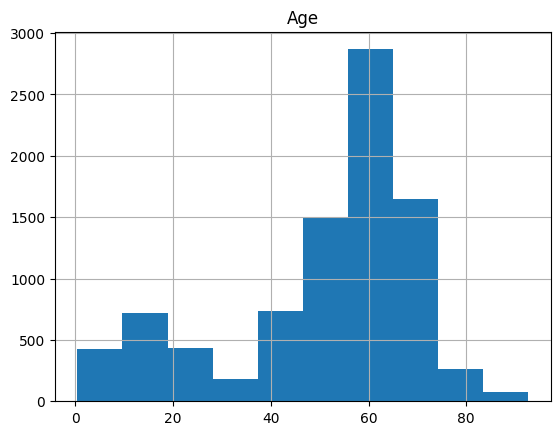

In [536]:
hilic_pos.hist(column='Age')

<Axes: xlabel='Count', ylabel='Study ID'>

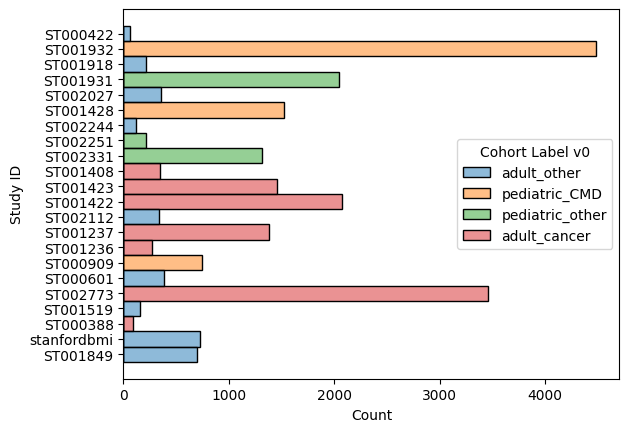

In [537]:
sns.histplot(y='Study ID', hue='Cohort Label v0', data=hilic_pos)

<Axes: xlabel='Cohort Label v0', ylabel='count'>

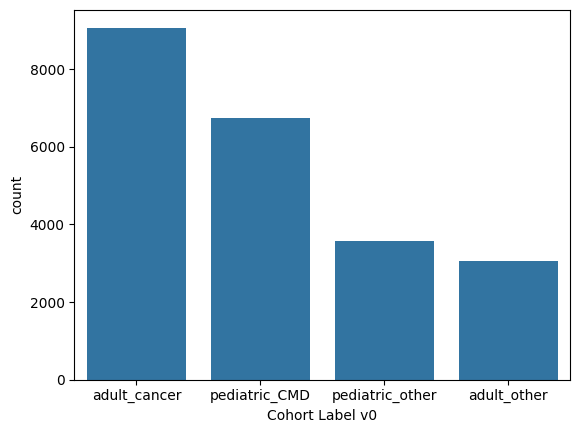

In [538]:
sns.barplot(hilic_pos['Cohort Label v0'].value_counts())

In [539]:
hilic_pos['Study ID'].value_counts()
# missing some of the ST001423, ST001422

Study ID
ST001932       4482
ST002773       3455
ST001422       2076
ST001931       2044
ST001428       1522
ST001423       1455
ST001237       1379
ST002331       1315
ST000909        742
stanfordbmi     726
ST001849        700
ST000601        384
ST002027        356
ST001408        349
ST002112        335
ST001918        273
ST001236        271
ST002251        269
ST001519        158
ST002244        122
ST000388         94
ST000422         60
Name: count, dtype: int64

In [540]:

previous_intensity_file = "/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/subset_robust_Freq, Cohort Log Size Weighted_0.2_rem_['549', '551', '547']_recompute/X.csv"
previous_nans_file = "/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/subset_robust_Freq, Cohort Log Size Weighted_0.2_rem_['549', '551', '547']_recompute/nans.csv"
previous_metadata_file = "/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/subset_robust_Freq, Cohort Log Size Weighted_0.2_rem_['549', '551', '547']_recompute/y.csv"
previous_intensity = pd.read_csv(previous_intensity_file, index_col=0)
previous_metadata = pd.read_csv(previous_metadata_file, index_col=0)

In [541]:
previous_metadata.columns

Index(['cohort_id', 'Study ID', 'Cohort Label', 'Cohort ID Expanded',
       'Study ID Expanded', 'Cohort ID', 'OS', 'OS_Event', 'Age', 'subject ID',
       'study_week', 'Region', 'Sex', 'Race', 'Dose (mg/kg)', 'phase',
       'Treatment', 'Prior_2', 'batch_id', 'runtime_hour', 'run_order',
       'MSKCC', 'ORR', 'Benefit', 'ExtremeResponder', 'PFS', 'PFS_Event', 'MV',
       'Age_Group', 'Benefit BINARY', 'Benefit ORDINAL', 'Nivo Benefit BINARY',
       'MSKCC BINARY', 'MSKCC ORDINAL', 'Matt Set', 'Set'],
      dtype='object')

In [542]:
previous_metadata.shape

(17685, 36)

In [543]:
previous_metadata['Study ID Expanded'].value_counts()

Study ID Expanded
ST001932    4482
ST001422    2051
ST001931    2044
ST001428    1522
ST001237    1379
ST002331    1315
ST001423    1192
ST000909     742
ST001849     691
ST002027     356
ST001408     349
ST002112     335
ST001236     271
ST001918     271
ST002251     242
ST001519     166
ST002244     122
ST000388      95
ST000422      60
Name: count, dtype: int64

In [544]:
# drop the 

kept_previous = previous_metadata[~previous_metadata['Study ID Expanded'].isin(['ST000601','ST001422','ST001423'])].copy()

In [545]:
kept_previous_files = kept_previous.index.to_list()

In [592]:
previous_intensity.shape

(17685, 2736)

In [546]:
saved_files = os.listdir(save_dir)
all_intensity = previous_intensity.loc[kept_previous_files].copy()
for file in saved_files:
    if 'scaled_intensity_matrix' in file:
        print(file)
        new_intensity = pd.read_csv(f'{save_dir}/{file}', index_col=0)
        print(new_intensity.shape)
        missing_cols = [x for x in all_intensity.columns if x not in new_intensity.columns]

        missing_mat = np.repeat(new_intensity.mean(axis=1).values, len(missing_cols)).reshape(new_intensity.shape[0], len(missing_cols))
        missing_mat = pd.DataFrame(missing_mat, index=new_intensity.index, columns=missing_cols)
        new_intensity = pd.concat([new_intensity, missing_mat], axis=1)

        all_intensity = pd.concat([all_intensity, new_intensity])

        print(all_intensity.shape)



ST001423_scaled_intensity_matrix.csv
ST001422_scaled_intensity_matrix.csv
ST000601_scaled_intensity_matrix.csv
stanford_hmp2_scaled_intensity_matrix.csv
shanghai_lung_cancer_scaled_intensity_matrix.csv


In [644]:
all_intensity.shape

(22288, 3226)

In [547]:
all_intensity.to_csv(f'{save_dir}/all_intensity_matrix.csv')

In [620]:
previous_nans = pd.read_csv(previous_nans_file, index_col=0)
saved_files = os.listdir(save_dir)
all_nans = previous_nans.loc[kept_previous_files].copy()

In [626]:
all_nans = all_nans.astype(int)

In [627]:
all_nans

,FT10031,FT10035,FT10037,FT10039,FT10041,FT10042,FT10044,FT1006,FT10068,FT1007,...,FT9951,FT9975,FT9978,FT9980,FT9984,FT9985,FT9988,FT9989,FT9997,FT9999
VT_171028_M314_167.mzML,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
VT_170729_M021_175.mzML,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
YW_200307_M431_189.mzML,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
VT_181116_M338_047.mzML,1,1,1,1,1,1,0,1,1,1,...,1,1,0,1,1,1,1,1,1,1
VT_170729_M021_179.mzML,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0780a_Marios_PD1_Inhib2_HP-PREFA41.mzML,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0900b_Marios_PD1_Inhib2_HP-PREFB47.mzML,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1200a_Marios_PD1_Inhib2_HP-PREFA62.mzML,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0960b_Marios_PD1_Inhib2_HP-PREFB50.mzML,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [618]:
all_nans = all_nans.astype(int)

for file in saved_files:
    if 'nan_matrix' in file:
        print(file)
        new_nans = pd.read_csv(f'{save_dir}/{file}', index_col=0)
        new_int = pd.read_csv(f'{save_dir}/{file.replace("nan_matrix","scaled_intensity_matrix")}', index_col=0)

        # if 'FT' not in new_nans.columns[0][:2]:
        #     new_nans = new_nans.T

        # missing_cols = [x for x in all_nans.columns if x not in new_nans.columns]

        # missing_mat = np.repeat(new_nans.mean(axis=1).values, len(missing_cols)).reshape(new_nans.shape[0], len(missing_cols))
        # missing_mat[:,:] = False
        # missing_mat = pd.DataFrame(missing_mat, index=new_nans.index, columns=missing_cols)
        # new_nans = pd.concat([new_nans, missing_mat], axis=1)
        # break
        new_nans = new_nans.astype(int)
        

        print(new_nans.shape)
        all_nans = pd.concat([all_nans, new_nans],axis=0)
        print(all_nans.shape)

        break



ST001422_nan_matrix.csv
(2075, 1744)
(4811, 16186)


In [642]:
previous_intensity2 = previous_intensity.loc[kept_previous_files].copy()


In [637]:
temp = pd.concat([all_nans, new_nans],axis=0)

In [643]:
[x for x in new_int.columns if x not in previous_intensity2.columns]

['FT10046',
 'FT10071',
 'FT10098',
 'FT10186',
 'FT10286',
 'FT10309',
 'FT10422',
 'FT10467',
 'FT10642',
 'FT10779',
 'FT10885',
 'FT10933',
 'FT11027',
 'FT11066',
 'FT11110',
 'FT11141',
 'FT11149',
 'FT11184',
 'FT11212',
 'FT11287',
 'FT11300',
 'FT11303',
 'FT11338',
 'FT11345',
 'FT11359',
 'FT11394',
 'FT11511',
 'FT11522',
 'FT11542',
 'FT11557',
 'FT11583',
 'FT11624',
 'FT11631',
 'FT11719',
 'FT11723',
 'FT11753',
 'FT11778',
 'FT1189',
 'FT1668',
 'FT1809',
 'FT1870',
 'FT1991',
 'FT2011',
 'FT2240',
 'FT2259',
 'FT2507',
 'FT2515',
 'FT2628',
 'FT2703',
 'FT2800',
 'FT2841',
 'FT3011',
 'FT3078',
 'FT3121',
 'FT313',
 'FT327',
 'FT3299',
 'FT3357',
 'FT3366',
 'FT338',
 'FT3497',
 'FT3557',
 'FT357',
 'FT3592',
 'FT3709',
 'FT3767',
 'FT3875',
 'FT3880',
 'FT3892',
 'FT3950',
 'FT4084',
 'FT4195',
 'FT4262',
 'FT4297',
 'FT4347',
 'FT4373',
 'FT4401',
 'FT4406',
 'FT4414',
 'FT442',
 'FT4575',
 'FT4586',
 'FT4642',
 'FT4845',
 'FT4859',
 'FT4869',
 'FT4876',
 'FT4912',


In [ ]:
[x for x in new_nans.columns if x not in all_nans.columns]

In [641]:
[x for x in new_nans.columns if x not in all_nans.columns]

['FT10046',
 'FT10071',
 'FT10098',
 'FT10186',
 'FT10286',
 'FT10309',
 'FT10422',
 'FT10467',
 'FT10642',
 'FT10779',
 'FT10885',
 'FT10933',
 'FT11027',
 'FT11066',
 'FT11110',
 'FT11141',
 'FT11149',
 'FT11184',
 'FT11212',
 'FT11287',
 'FT11300',
 'FT11303',
 'FT11338',
 'FT11345',
 'FT11359',
 'FT11394',
 'FT11511',
 'FT11522',
 'FT11542',
 'FT11557',
 'FT11583',
 'FT11624',
 'FT11631',
 'FT11719',
 'FT11723',
 'FT11753',
 'FT11778',
 'FT1189',
 'FT1668',
 'FT1809',
 'FT1870',
 'FT1991',
 'FT2011',
 'FT2240',
 'FT2259',
 'FT2507',
 'FT2515',
 'FT2628',
 'FT2703',
 'FT2800',
 'FT2841',
 'FT3011',
 'FT3078',
 'FT3121',
 'FT313',
 'FT327',
 'FT3299',
 'FT3357',
 'FT3366',
 'FT338',
 'FT3497',
 'FT3557',
 'FT357',
 'FT3592',
 'FT3709',
 'FT3767',
 'FT3875',
 'FT3880',
 'FT3892',
 'FT3950',
 'FT4084',
 'FT4195',
 'FT4262',
 'FT4297',
 'FT4347',
 'FT4373',
 'FT4401',
 'FT4406',
 'FT4414',
 'FT442',
 'FT4575',
 'FT4586',
 'FT4642',
 'FT4845',
 'FT4859',
 'FT4869',
 'FT4876',
 'FT4912',


In [639]:
all_nans

,FT10031,FT10035,FT10037,FT10039,FT10041,FT10042,FT10044,FT1006,FT10068,FT1007,...,FT9951,FT9975,FT9978,FT9980,FT9984,FT9985,FT9988,FT9989,FT9997,FT9999
VT_171028_M314_167.mzML,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
VT_170729_M021_175.mzML,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
YW_200307_M431_189.mzML,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
VT_181116_M338_047.mzML,1,1,1,1,1,1,0,1,1,1,...,1,1,0,1,1,1,1,1,1,1
VT_170729_M021_179.mzML,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0780a_Marios_PD1_Inhib2_HP-PREFA41.mzML,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0900b_Marios_PD1_Inhib2_HP-PREFB47.mzML,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1200a_Marios_PD1_Inhib2_HP-PREFA62.mzML,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0960b_Marios_PD1_Inhib2_HP-PREFB50.mzML,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [638]:
len(temp.columns.unique())

2874

In [623]:
new_nans

,FT10037,FT10039,FT10041,FT10042,FT10044,FT10046,FT1006,FT1007,FT10071,FT10089,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_160120_001.mzML,1,1,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
VT_160120_003.mzML,1,1,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
VT_160120_005.mzML,1,1,0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
VT_160120_007.mzML,1,1,0,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
VT_160120_009.mzML,1,1,0,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT_160226_135.mzML,1,1,1,1,0,1,1,1,1,1,...,1,0,0,0,0,0,0,1,0,1
VT_160226_137.mzML,1,1,1,1,0,1,0,1,1,1,...,1,0,0,0,0,0,0,1,0,0
VT_160226_139.mzML,1,1,1,1,1,1,0,1,1,1,...,1,0,0,0,0,0,0,1,0,1
VT_160226_141.mzML,1,1,1,1,1,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,1


In [622]:
new_nans.shape

(2075, 1744)

In [619]:
all_nans.shape

(16186, 4811)

In [617]:
new_nans

,FT10037,FT10039,FT10041,FT10042,FT10044,FT10046,FT1006,FT1007,FT10071,FT10089,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_160120_001.mzML,1,1,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
VT_160120_003.mzML,1,1,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
VT_160120_005.mzML,1,1,0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
VT_160120_007.mzML,1,1,0,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
VT_160120_009.mzML,1,1,0,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT_160226_135.mzML,1,1,1,1,0,1,1,1,1,1,...,1,0,0,0,0,0,0,1,0,1
VT_160226_137.mzML,1,1,1,1,0,1,0,1,1,1,...,1,0,0,0,0,0,0,1,0,0
VT_160226_139.mzML,1,1,1,1,1,1,0,1,1,1,...,1,0,0,0,0,0,0,1,0,1
VT_160226_141.mzML,1,1,1,1,1,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,1


In [605]:
all_nans

,FT10031,FT10035,FT10037,FT10039,FT10041,FT10042,FT10044,FT1006,FT10068,FT1007,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_171028_M314_167.mzML,True,True,True,True,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT_170729_M021_175.mzML,True,True,True,True,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YW_200307_M431_189.mzML,True,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT_181116_M338_047.mzML,True,True,True,True,True,True,False,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT_170729_M021_179.mzML,True,True,True,True,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT_160226_135.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,False,True,False,True
VT_160226_137.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,False,True,False,False
VT_160226_139.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,False,True,False,True
VT_160226_141.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,False,True,False,True


In [604]:
new_nans

,FT10037,FT10039,FT10041,FT10042,FT10044,FT10046,FT1006,FT1007,FT10071,FT10089,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_160120_001.mzML,True,True,True,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,True,False,True
VT_160120_003.mzML,True,True,False,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
VT_160120_005.mzML,True,True,False,False,True,True,False,True,False,False,...,False,True,False,False,False,False,False,True,False,True
VT_160120_007.mzML,True,True,False,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
VT_160120_009.mzML,True,True,False,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT_160226_135.mzML,True,True,True,True,False,True,True,True,True,True,...,True,False,False,False,False,False,False,True,False,True
VT_160226_137.mzML,True,True,True,True,False,True,False,True,True,True,...,True,False,False,False,False,False,False,True,False,False
VT_160226_139.mzML,True,True,True,True,True,True,False,True,True,True,...,True,False,False,False,False,False,False,True,False,True
VT_160226_141.mzML,True,True,True,True,True,True,False,True,False,True,...,True,False,False,False,False,False,False,True,False,True


In [602]:
new_nans

,FT10037,FT10039,FT10041,FT10042,FT10044,FT10046,FT1006,FT1007,FT10071,FT10089,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_160120_001.mzML,True,True,True,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,True,False,True
VT_160120_003.mzML,True,True,False,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
VT_160120_005.mzML,True,True,False,False,True,True,False,True,False,False,...,False,True,False,False,False,False,False,True,False,True
VT_160120_007.mzML,True,True,False,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
VT_160120_009.mzML,True,True,False,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT_160226_135.mzML,True,True,True,True,False,True,True,True,True,True,...,True,False,False,False,False,False,False,True,False,True
VT_160226_137.mzML,True,True,True,True,False,True,False,True,True,True,...,True,False,False,False,False,False,False,True,False,False
VT_160226_139.mzML,True,True,True,True,True,True,False,True,True,True,...,True,False,False,False,False,False,False,True,False,True
VT_160226_141.mzML,True,True,True,True,True,True,False,True,False,True,...,True,False,False,False,False,False,False,True,False,True


In [599]:
all_nans.shape

(20667, 2874)

In [597]:
new_nans.shape

(2075, 1744)

In [596]:
new_int.shape

(2075, 1744)

In [598]:
new_int

,FT10037,FT10039,FT10041,FT10042,FT10044,FT10046,FT1006,FT1007,FT10071,FT10089,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_160120_001.mzML,0.093245,0.087186,0.146938,-0.113207,0.193099,0.045698,0.220885,0.162623,-7.049922,2.928353,...,0.123150,5.830387,7.862187,2.201605,6.725855,8.319380,2.192188,0.256119,1.037220,0.331534
VT_160120_003.mzML,0.093245,0.087186,-0.755285,0.668846,0.193099,0.045698,-0.068341,0.162623,-5.403614,3.017734,...,0.123150,6.130938,8.362752,1.892175,7.114798,7.778943,2.756604,-2.357894,0.727733,0.331534
VT_160120_005.mzML,0.093245,0.087186,-1.552251,0.355667,0.193099,0.045698,1.260408,0.162623,-4.655655,2.758262,...,-1.851469,0.189385,7.967557,1.913950,6.892009,7.738552,2.290906,0.256119,0.722744,0.331534
VT_160120_007.mzML,0.093245,0.087186,-0.164735,-0.074477,0.193099,0.045698,0.135376,0.162623,1.703833,0.072271,...,0.123150,0.493929,1.475314,1.303236,0.439633,2.856194,1.327647,-0.207083,0.172619,0.331534
VT_160120_009.mzML,0.093245,0.087186,0.462431,-0.199698,0.193099,0.045698,1.846729,0.162623,0.314088,0.072271,...,0.123150,0.606838,-1.099593,1.690783,-1.886159,1.503944,0.669335,0.998173,0.040919,0.331534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT_160226_135.mzML,0.093245,0.087186,0.146938,0.117229,-1.626793,0.045698,0.204914,0.162623,0.114068,0.072271,...,0.123150,-0.886139,-0.677279,-0.167225,-1.336225,0.367993,0.094666,0.256119,0.174173,0.331534
VT_160226_137.mzML,0.093245,0.087186,0.146938,0.117229,-1.551893,0.045698,0.429783,0.162623,0.114068,0.072271,...,0.123150,0.119782,-0.885039,-0.048337,-0.451324,-0.058759,0.334952,0.256119,0.161167,-2.464373
VT_160226_139.mzML,0.093245,0.087186,0.146938,0.117229,0.193099,0.045698,1.813546,0.162623,0.114068,0.072271,...,0.123150,2.143580,2.332047,4.921189,1.021539,1.809844,5.671010,0.256119,-1.215273,0.331534
VT_160226_141.mzML,0.093245,0.087186,0.146938,0.117229,0.193099,0.045698,1.428069,0.162623,-5.448842,0.072271,...,0.123150,2.322336,2.471448,4.681173,1.684924,2.469160,6.261239,0.256119,-1.632521,0.331534


In [591]:
new_nans

,FT10037,FT10039,FT10041,FT10042,FT10044,FT10046,FT1006,FT1007,FT10071,FT10089,...,FT9905,FT9907,FT9917,FT9928,FT9931,FT9935,FT9951,FT9972,FT9975,FT9980
VT_160120_001.mzML,True,True,True,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,True,False,True
VT_160120_003.mzML,True,True,False,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
VT_160120_005.mzML,True,True,False,False,True,True,False,True,False,False,...,False,True,False,False,False,False,False,True,False,True
VT_160120_007.mzML,True,True,False,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
VT_160120_009.mzML,True,True,False,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VT_160226_135.mzML,True,True,True,True,False,True,True,True,True,True,...,True,False,False,False,False,False,False,True,False,True
VT_160226_137.mzML,True,True,True,True,False,True,False,True,True,True,...,True,False,False,False,False,False,False,True,False,False
VT_160226_139.mzML,True,True,True,True,True,True,False,True,True,True,...,True,False,False,False,False,False,False,True,False,True
VT_160226_141.mzML,True,True,True,True,True,True,False,True,False,True,...,True,False,False,False,False,False,False,True,False,True


In [553]:
new_nans

,FT10031,FT10041,FT10044,FT1006,FT10068,FT10089,FT10091,FT10094,FT10095,FT10097,...,FT9911,FT9913,FT9914,FT9923,FT9978,FT9980,FT9984,FT9985,FT9988,FT9997
ZN3TBJM-1013_HILIC-pos-B1.mzML,True,False,True,True,True,False,False,False,False,False,...,False,False,False,False,True,True,True,True,False,True
ZNED4XZ-4014_HILIC-pos-B1.mzML,True,False,True,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,True,False,True
ZLZNCLZ-2013_HILIC-pos-B1.mzML,True,True,True,True,True,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,True
ZLZQMEV-07_HILIC-pos-B1.mzML,True,False,True,True,True,False,False,False,False,False,...,False,False,False,False,True,True,False,True,False,True
ZN0JE53-02_HILIC-pos-B1.mzML,True,False,True,True,True,False,False,False,False,False,...,False,False,False,True,True,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exercise_HILIC-pos_ZN3TBJM-E17.mzML,False,False,True,True,True,False,False,True,False,False,...,True,False,False,False,False,True,False,True,False,False
Exercise_HILIC-pos_ZPMBHPS-E18.mzML,False,True,True,True,True,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
Exercise_HILIC-pos_ZPEL6L3-E18.mzML,False,True,True,True,True,False,False,True,False,False,...,False,False,False,True,False,True,False,True,False,False
Exercise_HILIC-pos_ZWFDEY0-E18.mzML,False,False,True,True,True,False,False,True,False,False,...,False,False,False,False,False,True,False,True,True,True


In [551]:
previous_nans

,FT10031,FT10035,FT10037,FT10039,FT10041,FT10042,FT10044,FT1006,FT10068,FT1007,...,FT9951,FT9975,FT9978,FT9980,FT9984,FT9985,FT9988,FT9989,FT9997,FT9999
VT_171028_M314_167.mzML,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
VT_170729_M021_175.mzML,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
YW_200307_M431_189.mzML,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
VT_181116_M338_047.mzML,True,True,True,True,True,True,False,True,True,True,...,True,True,False,True,True,True,True,True,True,True
VT_170729_M021_179.mzML,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0780a_Marios_PD1_Inhib2_HP-PREFA41.mzML,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
0900b_Marios_PD1_Inhib2_HP-PREFB47.mzML,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1200a_Marios_PD1_Inhib2_HP-PREFA62.mzML,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0960b_Marios_PD1_Inhib2_HP-PREFB50.mzML,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [495]:
'FT10031' in new_nans.columns

False

In [552]:
all_nans

,FT10031,FT10035,FT10037,FT10039,FT10041,FT10042,FT10044,FT1006,FT10068,FT1007,...,FT8832,FT8971,FT9101,FT9103,FT9339,FT9421,FT9449,FT9525,FT9710,FT9730
VT_171028_M314_167.mzML,True,True,True,True,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT_170729_M021_175.mzML,True,True,True,True,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YW_200307_M431_189.mzML,True,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT_181116_M338_047.mzML,True,True,True,True,True,True,False,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT_170729_M021_179.mzML,True,True,True,True,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exercise_HILIC-pos_ZN3TBJM-E17.mzML,False,NaN,NaN,NaN,False,NaN,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise_HILIC-pos_ZPMBHPS-E18.mzML,False,NaN,NaN,NaN,True,NaN,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise_HILIC-pos_ZPEL6L3-E18.mzML,False,NaN,NaN,NaN,True,NaN,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise_HILIC-pos_ZWFDEY0-E18.mzML,False,NaN,NaN,NaN,False,NaN,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [475]:
new_nans.shape

(726, 1767)

In [473]:
all_nans

,FT10031,FT10035,FT10037,FT10039,FT10041,FT10042,FT10044,FT1006,FT10068,FT1007,...,FT2737,FT2760,FT2763,FT2774,FT2765,FT171,FT159,FT2796,FT168,FT2848
VT_171028_M314_167.mzML,True,True,True,True,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT_170729_M021_175.mzML,True,True,True,True,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YW_200307_M431_189.mzML,True,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT_181116_M338_047.mzML,True,True,True,True,True,True,False,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT_170729_M021_179.mzML,True,True,True,True,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exercise_HILIC-pos_ZN3TBJM-E17.mzML,False,NaN,NaN,NaN,False,NaN,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise_HILIC-pos_ZPMBHPS-E18.mzML,False,NaN,NaN,NaN,True,NaN,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise_HILIC-pos_ZPEL6L3-E18.mzML,False,NaN,NaN,NaN,True,NaN,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise_HILIC-pos_ZWFDEY0-E18.mzML,False,NaN,NaN,NaN,False,NaN,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [474]:
all_nans.to_csv(f'{save_dir}/all_nans.csv')        

KeyboardInterrupt: 

In [448]:
all_intensity.shape

(22288, 5560)

In [449]:
previous_metadata['Previous Study ID'] = previous_metadata['Study ID Expanded']
previous_metadata['Previous Job ID'] = previous_metadata['cohort_id']
previous_metadata['Matt Set Label'] = previous_metadata['Matt Set']
previous_metadata['Previous Set'] = previous_metadata['Set']
hilic_pos_metadata = hilic_pos.join(previous_metadata[['Previous Study ID','Previous Job ID','Matt Set Label','Previous Set']],how='outer')
print(hilic_pos_metadata.shape)


(22586, 43)


In [456]:

study_id_list = hilic_pos['Study ID'].unique()
all_save_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/data_2024_July_08'                                             
                                             
for study_id in study_id_list:
    scaled_int_file = f'{all_save_dir}/{study_id}_scaled_intensity_matrix.csv'
    if os.path.exists(scaled_int_file):
        print('---')
        print(f'{study_id} already exists')
        continue

    print('------')
    print(study_id)
    subset_metadata = hilic_pos[hilic_pos['Study ID'] == study_id].copy()
    print(subset_metadata.shape)
    subset_samples = subset_metadata.index.to_list()
    print('N samples in metadata:', len(subset_samples))
    common_subset_samples = [x for x in subset_samples if x in all_intensity.index]
    print('N samples in common with intensity matrix:', len(common_subset_samples))

    if  len(common_subset_samples) < 0.8 * len(subset_samples):
        print('!!! Not enough samples to use this study !!!')
        break

    subset_metadata.loc[common_subset_samples,:].to_csv(f'{all_save_dir}/{study_id}_metadata.csv')
    subset_intensity = all_intensity.loc[common_subset_samples].copy()
    
    subset_nans = all_nans.loc[common_subset_samples].copy()
    subset_nans.to_csv(f'{all_save_dir}/{study_id}_nans.csv')

    # fill in the missing values with the mean of the feature (this should already be done)
    # subset_intensity.fillna(subset_intensity.mean(), inplace=True)

    if subset_intensity.isna().sum().sum() > 0:
        scaler = StandardScaler()
        subset_intensity_scaled = scaler.fit_transform(subset_intensity)
        subset_intensity_scaled = pd.DataFrame(subset_intensity_scaled, index=subset_intensity.index, columns=subset_intensity.columns)

        subset_intensity_scaled = subset_intensity_scaled.T
        subset_intensity_scaled.fillna(subset_intensity_scaled.mean(), inplace=True)

    else:
        subset_intensity_scaled = subset_intensity.copy()

    subset_intensity_scaled.T.to_csv(f'{all_save_dir}/{study_id}_scaled_intensity_matrix.csv')
    


------
ST000422
(60, 39)
N samples in metadata: 60
N samples in common with intensity matrix: 60


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST001932
(4482, 39)
N samples in metadata: 4482
N samples in common with intensity matrix: 4482


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST001918
(273, 39)
N samples in metadata: 273
N samples in common with intensity matrix: 271


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST001931
(2044, 39)
N samples in metadata: 2044
N samples in common with intensity matrix: 2044


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST002027
(356, 39)
N samples in metadata: 356
N samples in common with intensity matrix: 356


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST001428
(1522, 39)
N samples in metadata: 1522
N samples in common with intensity matrix: 1522


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST002244
(122, 39)
N samples in metadata: 122
N samples in common with intensity matrix: 122


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST002251
(269, 39)
N samples in metadata: 269
N samples in common with intensity matrix: 242


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST002331
(1315, 39)
N samples in metadata: 1315
N samples in common with intensity matrix: 1315


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST001408
(349, 39)
N samples in metadata: 349
N samples in common with intensity matrix: 349


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST001423
(1455, 39)
N samples in metadata: 1455
N samples in common with intensity matrix: 1197


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST001422
(2076, 39)
N samples in metadata: 2076
N samples in common with intensity matrix: 2075


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST002112
(335, 39)
N samples in metadata: 335
N samples in common with intensity matrix: 335


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST001237
(1379, 39)
N samples in metadata: 1379
N samples in common with intensity matrix: 1379


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST001236
(271, 39)
N samples in metadata: 271
N samples in common with intensity matrix: 271


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST000909
(742, 39)
N samples in metadata: 742
N samples in common with intensity matrix: 742


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST000601
(384, 39)
N samples in metadata: 384
N samples in common with intensity matrix: 384


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


------
ST002773
(3455, 39)
N samples in metadata: 3455
N samples in common with intensity matrix: 3455


KeyError: "None of [Index(['F076_200714_M331_001.mzML', 'F076_200714_M331_009.mzML',\n       'F076_200714_M331_017.mzML', 'F076_200714_M331_025.mzML',\n       'F076_200714_M331_033.mzML', 'F076_200714_M331_041.mzML',\n       'F076_200714_M331_049.mzML', 'F076_200714_M331_057.mzML',\n       'F076_200714_M331_065.mzML', 'F076_200714_M331_073.mzML',\n       ...\n       'F076_201011_M331_209.mzML', 'F076_201011_M331_217.mzML',\n       'F076_201011_M331_225.mzML', 'F076_201011_M331_233.mzML',\n       'F076_201011_M331_241.mzML', 'F076_201011_M331_249.mzML',\n       'F076_201011_M331_257.mzML', 'F076_201011_M331_265.mzML',\n       'F076_201011_M331_273.mzML', 'F076_201011_M331_281.mzML'],\n      dtype='object', length=3455)] are in the [index]"

In [467]:
all_nans.loc[common_subset_samples].copy()

,FT10031,FT10035,FT10037,FT10039,FT10041,FT10042,FT10044,FT1006,FT10068,FT1007,...,Exercise_HILIC-pos_ZMBVNFM-E17.mzML,Exercise_HILIC-pos_ZJXC41N-E14.mzML,Exercise_HILIC-pos_ZRB0F6P-E12.mzML,Exercise_HILIC-pos_ZTL5S2Y-E14.mzML,Exercise_HILIC-pos_ZMBVNFM-E11.mzML,Exercise_HILIC-pos_ZN3TBJM-E17.mzML,Exercise_HILIC-pos_ZPMBHPS-E18.mzML,Exercise_HILIC-pos_ZPEL6L3-E18.mzML,Exercise_HILIC-pos_ZWFDEY0-E18.mzML,Exercise_HILIC-pos_ZS78KHV-E17.mzML
F076_200714_M331_001.mzML,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F076_200714_M331_009.mzML,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F076_200714_M331_017.mzML,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F076_200714_M331_025.mzML,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F076_200714_M331_033.mzML,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F076_201011_M331_249.mzML,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F076_201011_M331_257.mzML,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F076_201011_M331_265.mzML,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F076_201011_M331_273.mzML,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
